In [1]:
import numpy as np
import matplotlib.pyplot as plt

def cross_product_matrix(k):
    """Creates the skew-symmetric cross-product matrix K for a vector k."""
    return np.array([0, -k[1], k[2]],
        [k[1], 0, -k],
        [-k[2], k
    ])

import numpy as np

def calculate_ellipticity_from_torque(intrinsic_inertia_tensor, tidal_field, C_torque=0.1):
    def levi_civita_symbol():
        e = np.zeros((3, 3, 3))
        e[0, 1, 2] = e[1, 2, 0] = e[2, 0, 1] = 1
        e[0, 2, 1] = e[1, 0, 2] = e[2, 1, 0] = -1
        return e

    epsilon = levi_civita_symbol()

    # Torque: L_i = ε_ijk * s_jl * I_lk
    torque_vector = np.einsum('ijk,jl,lk->i', epsilon, tidal_field, intrinsic_inertia_tensor)

    # Small-angle rotation vector: θ = C * L
    theta = C_torque * torque_vector
    angle = np.linalg.norm(theta)
    if angle == 0:
        R = np.eye(3)
    else:
        axis = theta / angle
        K = np.array([[0, -axis[2], axis[1]],
                      [axis[2], 0, -axis[0]],
                      [-axis[1], axis[0], 0]])
        R = np.eye(3) + np.sin(angle) * K + (1 - np.cos(angle)) * K @ K

    # Rotate inertia tensor
    rotated_inertia = R @ intrinsic_inertia_tensor @ R.T

    # Projected 2D components (onto x-y plane)
    I_xx = rotated_inertia[0, 0]
    I_yy = rotated_inertia[1, 1]
    I_xy = rotated_inertia[0, 1]

    denom = I_xx + I_yy
    if denom == 0:
        return 0.0, 0.0

    e_plus = (I_xx - I_yy) / denom
    e_cross = (2 * I_xy) / denom

    return e_plus, e_cross, rotated_inertia


# --- Main Calculation and Plotting ---

# Define the intrinsic inertia tensor for a disk-like (oblate) galaxy.
# It is flattened along its own z-axis (I_zz < I_xx = I_yy).
# This is the inertia tensor in the galaxy's own principal axis frame.
I_intrinsic_principal = np.array([[2.0, 0.1, 0.2],
                                    [0.1, -1.0, 0.3],
                                    [0.2, 0.3, -1.0]]) / 3.0

I_intrinsic_principal = np.array([[1.0, 0., 0.],
                   [0., 1, 0.],
                   [0., 0., 0.1]]) / 3.0

# Define a base tidal field, representing stretching along the x-axis
# and compression along y and z. It must be trace-free.
# Add off-diagonal elements to induce torque
# s_base = np.array([[1.0, 0.5, 0.2],
#                    [0., 1, 0.1],
#                    [0., 0., 1]]) / 3.0

s_base = np.array([[2.0, 0.1, 0.2],
                    [0.1, -1.0, 0.3],
                    [0.2, 0.3, -1.0]]) / 3.0




# Define a range of tidal field strengths to test.
tidal_strengths = np.linspace(0, 2000.0, 100)

# Initialize lists to store the results
e_plus_results = []
e_cross_results = []
I_obs = []

for strength in tidal_strengths:
    # Scale the tidal field by the current strength
    s_current = strength * s_base
    
    # Calculate the resulting ellipticity using the corrected method
    ep, ex, rI = calculate_ellipticity_from_torque(I_intrinsic_principal, s_current, C_torque=0.1)
    e_plus_results.append(ep)
    e_cross_results.append(ex)
    I_obs.append( rI )

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_ttt_ellipticity(I, s, epsilon=1e-6):
    """
    Compute observed ellipticity induced by tidal torque.
    
    Parameters
    ----------
    I : ndarray (3x3)
        Inertia tensor (symmetric)
    s : ndarray (3x3)
        Tidal shear tensor (symmetric, trace-free)
    A : float
        Alignment amplitude
    epsilon : float
        Small value to prevent division by zero
    
    Returns
    -------
    e_plus, e_cross : float
        Ellipticity components in x-y projection
    """
    # Levi-Civita symbol
    e = np.zeros((3, 3, 3))
    e[0, 1, 2] = e[1, 2, 0] = e[2, 0, 1] = 1
    e[0, 2, 1] = e[1, 0, 2] = e[2, 1, 0] = -1

    # Angular momentum: L_i = ε_ijk * s_jl * I_lk
    L = np.einsum('ijk,jl,lk->i', e, s, I)

    # Projected angular momentum (on x-y plane)
    Lx, Ly = L[0], L[1]
    L2 = Lx**2 + Ly**2 + epsilon
    e_plus = (Lx**2 - Ly**2) / L2
    e_cross = 2 * (Lx * Ly) / L2

    L = np.einsum('ijk,jk->i', e, I)
    Lx, Ly = L[0], L[1]
    L2 = Lx**2 + Ly**2 + epsilon
    e_plus_int = (Lx**2 - Ly**2) / L2
    e_cross_int = 2 * (Lx * Ly) / L2

    L = np.einsum('ijk,jk->i', e, s)
    Lx, Ly = L[0], L[1]
    L2 = Lx**2 + Ly**2 + epsilon
    e_plus_s = (Lx**2 - Ly**2) / L2
    e_cross_s = 2 * (Lx * Ly) / L2

    return e_plus, e_cross, e_plus_int, e_cross_int, e_plus_s, e_cross_s

In [3]:
def trace_free_sI(s, I):
    """
    Compute T_ij = s_ik I_kj - (1/3) δ_ij Tr(s_ik I_kj)
    
    Parameters:
    -----------
    s : (3,3) np.ndarray
        Symmetric tidal tensor.
    I : (3,3) np.ndarray
        Symmetric inertia tensor.
        
    Returns:
    --------
    T : (3,3) np.ndarray
        Trace-free symmetric tensor from s and I.
    """
    T_raw = s @ I
    trace_T = np.trace(T_raw)
    identity = np.eye(3)
    T = T_raw - (1/3) * trace_T * identity
    return T

def calculate_ttt_ellipticity(I, s, epsilon=1e-6):
    """
    Compute observed ellipticity induced by tidal torque.
    
    Parameters
    ----------
    I : ndarray (3x3)
        Inertia tensor (symmetric)
    s : ndarray (3x3)
        Tidal shear tensor (symmetric, trace-free)
    A : float
        Alignment amplitude
    epsilon : float
        Small value to prevent division by zero
    
    Returns
    -------
    e_plus, e_cross : float
        Ellipticity components in x-y projection
    """

    T = trace_free_sI(s, I)
    Lx, Ly = T[0, 0], T[1, 0]
    e_plus = T[0,0] - T[1,1]
    e_cross = 2 * T[0,1] / np.trace(s @ I) #* T[1,0] 

    T = trace_free_sI(I, I)
    Lx, Ly = T[0, 1], T[1, 0]
    e_plus_int = T[0,0] - T[1,1]
    e_cross_int = 2 * T[0,1] / np.trace(I @ I) #* T[1,0] 

    T = trace_free_sI(s, s)
    Lx, Ly = T[0, 1], T[1, 0]
    e_plus_s = T[0,0] - T[1,1]
    e_cross_s = 2 * T[0,1] / np.trace(s @ s ) #* T[1,0] / 

    print( T )

    return e_plus, e_cross, e_plus_int, e_cross_int, e_plus_s, e_cross_s

![image.png](attachment:image.png)

In [4]:
# --- Input Setup ---

# Inertia tensor of a flattened disk-like galaxy (in its principal frame)
I_intrinsic_lrg = np.array([
    [2.0, 0.1, 0.0],
    [0.1, 1.5, 0.0],
    [0.0, 0.0, 1.2]
])

I_intrinsic_disk = np.array([
    [1.0, 0.3, 0.2],
    [0.0, 1, 0.1],
    [0.0, 0.0, 0.1]
]) / 3.0

# Tidal shear tensor (trace-free with off-diagonal torque terms)
s_base = np.array([
    [4.0, 0.1, 0.2],
    [0.1, .0, 0.3],
    [0.2, 0.3, .0]
]) / 3.0

# s_base = np.array([
#     [1.0, 0.0, 0.0],
#     [0.0, 0.0, 0.0],
#     [0.0, 0.0, 0.0]
# ]) / 3.0

In [5]:
# Sweep over a range of field strengths
tidal_strengths = np.linspace(0.0, 5, 300)

e_plus_lrg, e_cross_lrg = [], []
e_plus_lrg_int, e_cross_lrg_int = [], []
e_plus_lrg_s, e_cross_lrg_s = [], []


e_plus_disk, e_cross_disk = [], []
e_plus_disk_int, e_cross_disk_int = [], []
e_plus_disk_s, e_cross_disk_s = [], []  

for strength in tidal_strengths:
        s_scaled = strength * s_base
        
        ep_lrg, ex_lrg, ep_lrg_int, ex_lrg_int, ep_lrg_s, ex_lrg_s = calculate_ttt_ellipticity(I_intrinsic_lrg, s_scaled )
        ep_disk, ex_disk, ep_disk_int, ex_disk_int, ep_disk_s, ex_disk_s = calculate_ttt_ellipticity(I_intrinsic_disk, s_scaled )

        e_plus_lrg.append(ep_lrg)
        e_cross_lrg.append(ex_lrg)
        e_plus_lrg_int.append(ep_lrg_int)
        e_cross_lrg_int.append(ex_lrg)
        e_plus_lrg_s.append(ep_lrg_s)
        e_cross_lrg_s.append(ex_lrg_s)

        e_plus_disk.append(ep_disk)
        e_cross_disk.append(ex_disk)
        e_plus_disk_int.append(ep_disk_int)
        e_cross_disk_int.append(ex_disk_int)
        e_plus_disk_s.append(ep_disk_s)
        e_cross_disk_s.append(ex_disk_s)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[ 3.30077508e-04  1.42926564e-05  2.57889236e-05]
 [ 1.42926564e-05 -1.65504819e-04  6.21419845e-07]
 [ 2.57889236e-05  6.21419845e-07 -1.64572689e-04]]
[[ 3.30077508e-04  1.42926564e-05  2.57889236e-05]
 [ 1.42926564e-05 -1.65504819e-04  6.21419845e-07]
 [ 2.57889236e-05  6.21419845e-07 -1.64572689e-04]]
[[ 1.32031003e-03  5.71706257e-05  1.03155694e-04]
 [ 5.71706257e-05 -6.62019275e-04  2.48567938e-06]
 [ 1.03155694e-04  2.48567938e-06 -6.58290756e-04]]
[[ 1.32031003e-03  5.71706257e-05  1.03155694e-04]
 [ 5.71706257e-05 -6.62019275e-04  2.48567938e-06]
 [ 1.03155694e-04  2.48567938e-06 -6.58290756e-04]]
[[ 2.97069757e-03  1.28633908e-04  2.32100312e-04]
 [ 1.28633908e-04 -1.48954337e-03  5.59277860e-06]
 [ 2.32100312e-04  5.59277860e-06 -1.48115420e-03]]
[[ 2.97069757e-03  1.28633908e-04  2.32100312e-04]
 [ 1.28633908e-04 -1.48954337e-03  5.59277860e-06]
 [ 2.32100312e-04  5.59277860e-06 -1.48115420e-03]]
[[

/tmp/ipykernel_461204/2929209897.py:47: RuntimeWarning: invalid value encountered in scalar divide
  e_cross = 2 * T[0,1] / np.trace(s @ I) #* T[1,0]
/tmp/ipykernel_461204/2929209897.py:57: RuntimeWarning: invalid value encountered in scalar divide
  e_cross_s = 2 * T[0,1] / np.trace(s @ s ) #* T[1,0] /


(-1.1, 1.1)

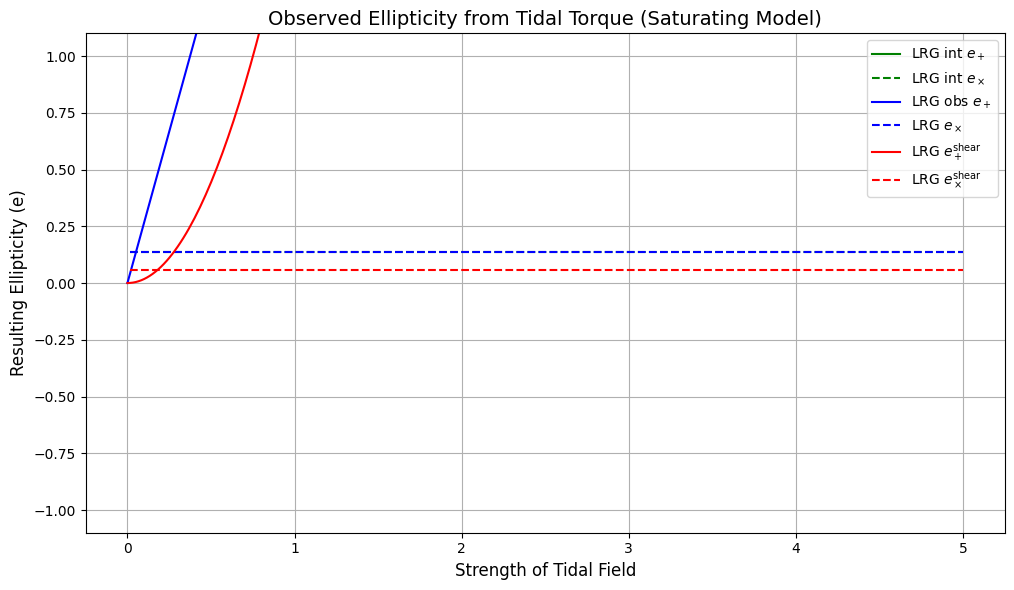

In [6]:
# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(tidal_strengths, e_plus_lrg_int, 'g-', label=r'LRG int $e_+$')
plt.plot(tidal_strengths, e_cross_lrg_int, 'g--', label=r'LRG int $e_\times$')

plt.plot(tidal_strengths, e_plus_lrg, 'b-', label=r'LRG obs $e_+$')
plt.plot(tidal_strengths, e_cross_lrg, 'b--', label=r'LRG $e_\times$')

plt.plot(tidal_strengths, e_plus_lrg_s, 'r-', label=r'LRG $e_+^{\rm shear}$')
plt.plot(tidal_strengths, e_cross_lrg_s, 'r--', label=r'LRG $e_\times^{\rm shear}$')

plt.xlabel("Strength of Tidal Field", fontsize=12)
plt.ylabel("Resulting Ellipticity (e)", fontsize=12)
plt.title("Observed Ellipticity from Tidal Torque (Saturating Model)", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim( -1.1  , 1.1)

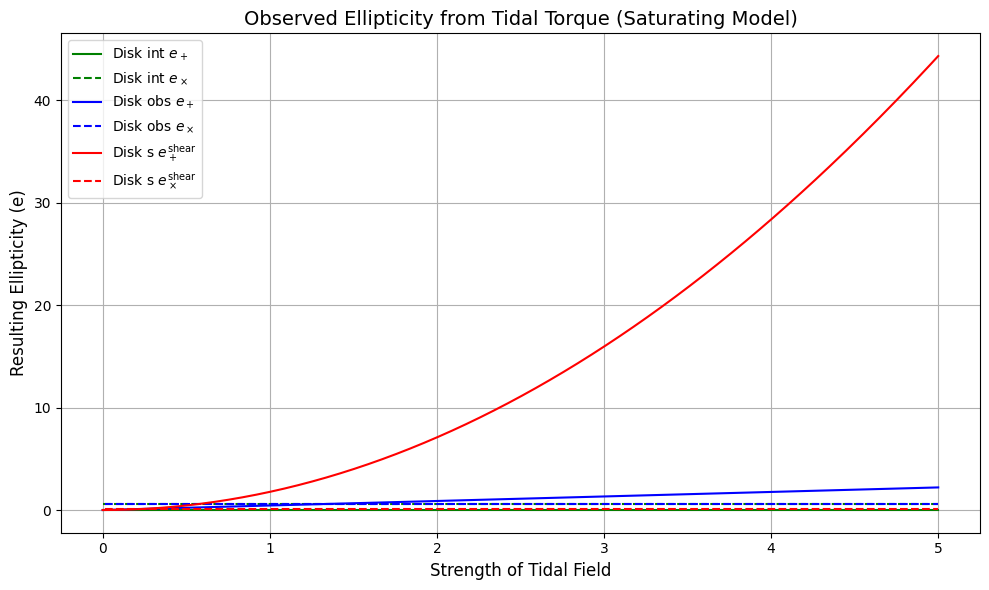

In [7]:
# --- Plotting ---
plt.figure(figsize=(10, 6))

plt.plot(tidal_strengths, e_plus_disk_int, 'g-', label=r'Disk int $e_+$')
plt.plot(tidal_strengths, e_cross_disk_int, 'g--', label=r'Disk int $e_\times$')

plt.plot(tidal_strengths, e_plus_disk, 'b-', label=r'Disk obs $e_+$')
plt.plot(tidal_strengths, e_cross_disk, 'b--', label=r'Disk obs $e_\times$')

plt.plot(tidal_strengths, e_plus_disk_s, 'r-', label=r'Disk s $e_+^{\rm shear}$')
plt.plot(tidal_strengths, e_cross_disk_s, 'r--', label=r'Disk s $e_\times^{\rm shear}$')

plt.xlabel("Strength of Tidal Field", fontsize=12)
plt.ylabel("Resulting Ellipticity (e)", fontsize=12)
plt.title("Observed Ellipticity from Tidal Torque (Saturating Model)", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

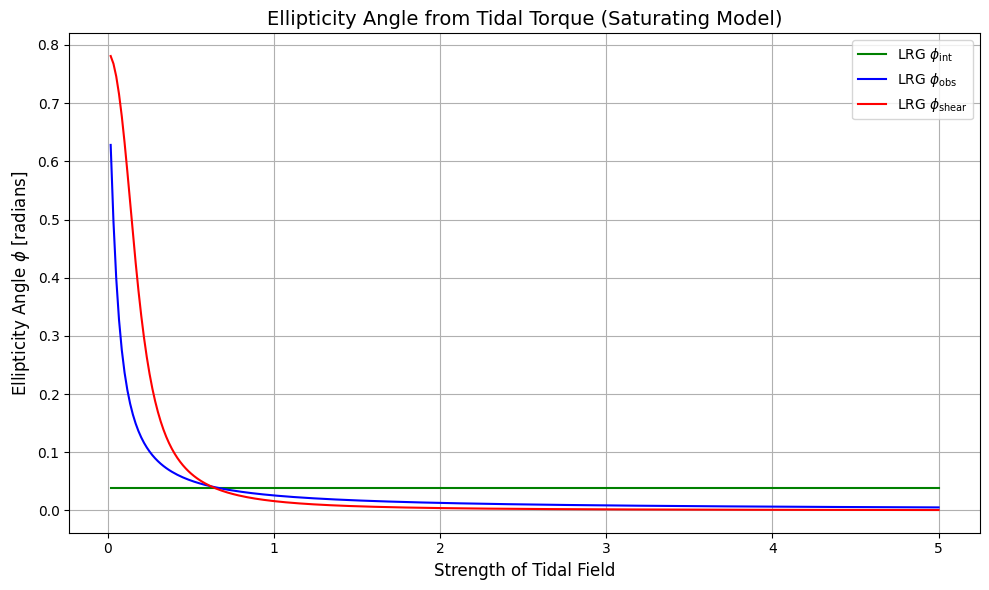

In [8]:
# --- Plotting angle phi ---
phi_lrg = 0.5 * np.angle(np.array(e_plus_lrg) + 1j * np.array(e_cross_lrg))
phi_lrg_int = 0.5 * np.angle(np.array(e_plus_lrg_int) + 1j * np.array(e_cross_lrg_int))
phi_lrg_s = 0.5 * np.angle(np.array(e_plus_lrg_s) + 1j * np.array(e_cross_lrg_s))

plt.figure(figsize=(10, 6))
plt.plot(tidal_strengths, phi_lrg_int, 'g-', label=r'LRG $\phi_{\rm int}$')
plt.plot(tidal_strengths, phi_lrg, 'b-', label=r'LRG $\phi_{\rm obs}$')
plt.plot(tidal_strengths, phi_lrg_s, 'r-', label=r'LRG $\phi_{\rm shear}$')

plt.xlabel("Strength of Tidal Field", fontsize=12)
plt.ylabel(r"Ellipticity Angle $\phi$ [radians]", fontsize=12)
plt.title("Ellipticity Angle from Tidal Torque (Saturating Model)", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

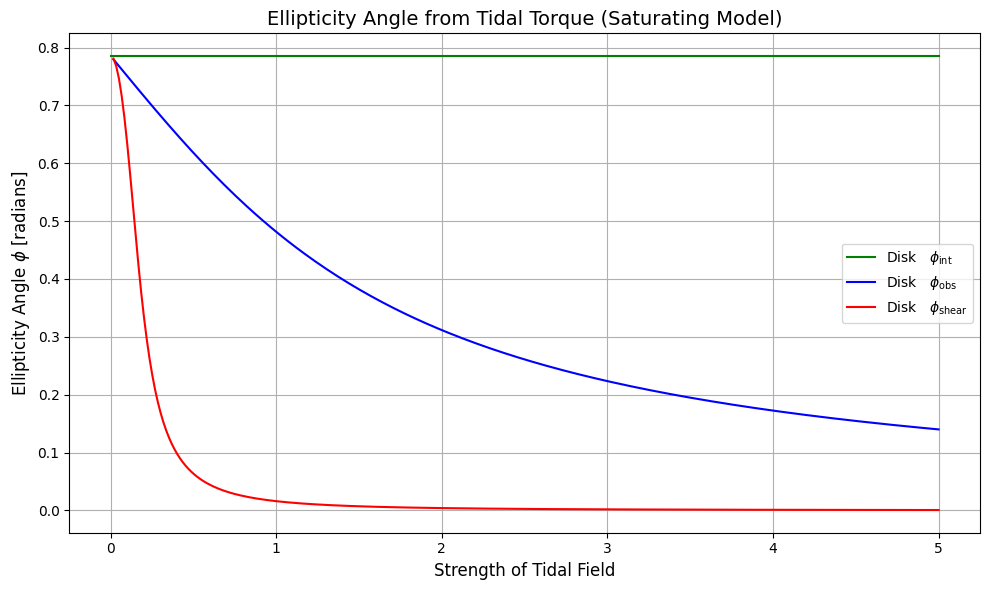

In [9]:
# --- Plotting angle phi ---
phi_disk = 0.5 * np.angle(np.array(e_plus_disk) + 1j * np.array(e_cross_disk))
phi_disk_int = 0.5 * np.angle(np.array(e_plus_disk_int) + 1j * np.array(e_cross_disk_int))
phi_disk_s = 0.5 * np.angle(np.array(e_plus_disk_s) + 1j * np.array(e_cross_disk_s))

plt.figure(figsize=(10, 6))
plt.plot(tidal_strengths, phi_disk_int, 'g-', label=r'Disk   $\phi_{\rm int}$')
plt.plot(tidal_strengths, phi_disk, 'b-', label=r'Disk   $\phi_{\rm obs}$')
plt.plot(tidal_strengths, phi_disk_s, 'r-', label=r'Disk   $\phi_{\rm shear}$')

plt.xlabel("Strength of Tidal Field", fontsize=12)
plt.ylabel(r"Ellipticity Angle $\phi$ [radians]", fontsize=12)
plt.title("Ellipticity Angle from Tidal Torque (Saturating Model)", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
def trace_free_sI(s, I):
    """
    Compute T_ij = s_ik I_kj - (1/3) δ_ij Tr(s_ik I_kj)
    
    Parameters:
    -----------
    s : (3,3) np.ndarray
        Symmetric tidal tensor.
    I : (3,3) np.ndarray
        Symmetric inertia tensor.
        
    Returns:
    --------
    T : (3,3) np.ndarray
        Trace-free symmetric tensor from s and I.
    """
    T_raw = s @ I
    trace_T = np.trace(T_raw)
    identity = np.eye(3)
    T = T_raw - (1/3) * trace_T * identity
    return T